In [3]:
pip install kaggle

In [4]:
mkdir ~/.kaggle

In [7]:
cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 427M/428M [00:01<00:00, 257MB/s]
100% 428M/428M [00:01<00:00, 238MB/s]


In [11]:
import zipfile
import os

with zipfile.ZipFile("tess.zip", "r") as zip_ref:
    zip_ref.extractall("tess")

    print(os.listdir("tess"))


['tess toronto emotional speech set data', 'TESS Toronto emotional speech set data']


In [12]:
DATASET_PATH = "/content/tess"
emotion_folders = os.listdir(DATASET_PATH)
print("Emotion Labels:", emotion_folders)

for emotion in emotion_folders:
    print(f"{emotion}: {len(os.listdir(os.path.join(DATASET_PATH, emotion)))} files")


Emotion Labels: ['tess toronto emotional speech set data', 'TESS Toronto emotional speech set data']
tess toronto emotional speech set data: 1 files
TESS Toronto emotional speech set data: 14 files


In [15]:
dataset_path = '/content/tess/TESS Toronto emotional speech set data'

emotion_folders = os.listdir(dataset_path)
print("Emotion Folders:", emotion_folders)

Emotion Folders: ['OAF_happy', 'OAF_Fear', 'OAF_neutral', 'OAF_Sad', 'YAF_pleasant_surprised', 'YAF_happy', 'OAF_angry', 'YAF_angry', 'YAF_sad', 'YAF_disgust', 'YAF_fear', 'YAF_neutral', 'OAF_Pleasant_surprise', 'OAF_disgust']


In [16]:
emotion_folder = emotion_folders[1]
emotion_folder_path = os.path.join(dataset_path, emotion_folder)

audio_files = os.listdir(emotion_folder_path)
print(f"Audio Files in '{emotion_folder}':", audio_files[:5])


Audio Files in 'OAF_Fear': ['OAF_ton_fear.wav', 'OAF_base_fear.wav', 'OAF_wash_fear.wav', 'OAF_date_fear.wav', 'OAF_shawl_fear.wav']


### Audio Processing

In [18]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

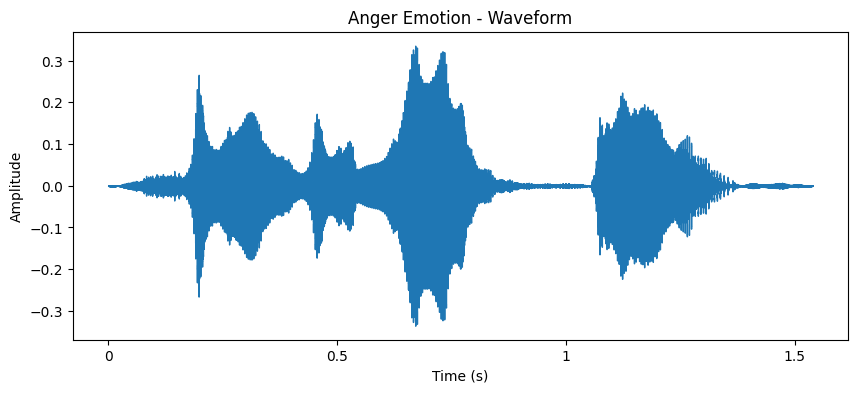

In [21]:
def plot_waveform(y, sr, title="Waveform"):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(y, sr=sr)
  plt.title(title)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.show()

anger1 = '/content/tess/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav'
y, sr = librosa.load(anger1, sr=22050)

plot_waveform(y, sr, title="Anger Emotion - Waveform")

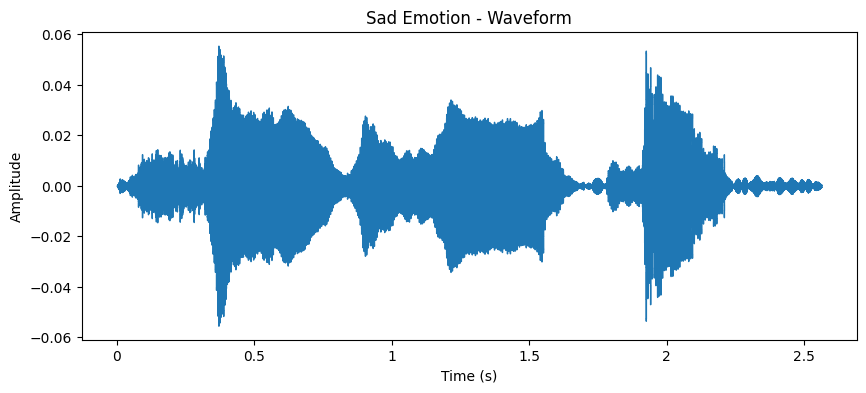

In [25]:
sad1 = '/content/tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad.wav'
y1, sr1 = librosa.load(sad1, sr=22050)

plot_waveform(y1, sr1, title="Sad Emotion - Waveform")

In [24]:
def plot_spectrogram(y, sr, title="Spectrogram"):
  plt.figure(figsize=(10, 4))
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
  plt.title(title)
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel("Time (s)")
  plt.ylabel("Frequency (Hz)")
  plt.show()

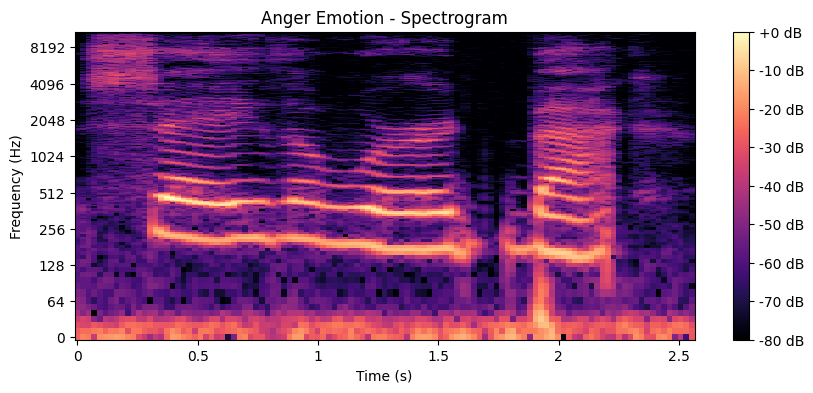

In [26]:
plot_spectrogram(y, sr, title="Anger Emotion - Spectrogram")

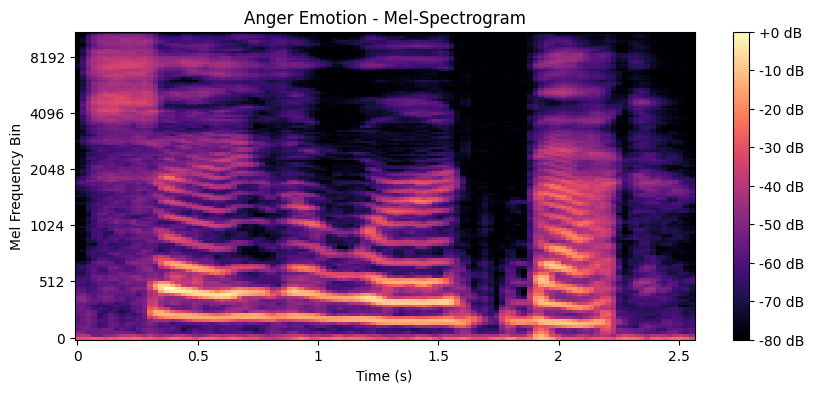

In [30]:
def plot_mel_spectrogram(y, sr, title="Mel-Spectrogram"):
  plt.figure(figsize=(10, 4))
  mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
  librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
  plt.title(title)
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel("Time (s)")
  plt.ylabel("Mel Frequency Bin")
  plt.show()

plot_mel_spectrogram(y, sr, title="Anger Emotion - Mel-Spectrogram")


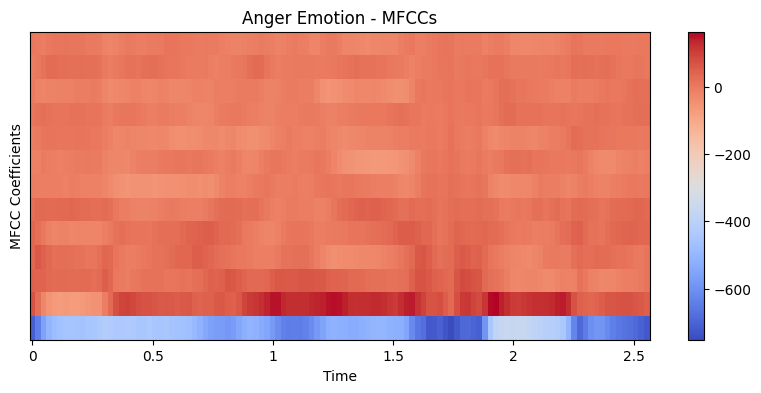

In [31]:
def plot_mfcc(y, sr, title="MFCCs"):
  plt.figure(figsize=(10, 4))
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  librosa.display.specshow(mfccs, x_axis='time')
  plt.title(title)
  plt.colorbar()
  plt.ylabel("MFCC Coefficients")
  plt.show()

plot_mfcc(y, sr, title="Anger Emotion - MFCCs")

In [35]:
sample_rate = 22050
N_mfcc = 13

In [36]:
def extract_mfcc(file_path):
  y, sr = librosa.load(file_path, sr=sample_rate)
  y_trimmed, _ = librosa.effects.trim(y)  # Trim silence
  mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=N_mfcc)
  return np.mean(mfccs.T, axis=0)  # Aggregate MFCCs

features, labels = [], []
for emotion_folder in emotion_folders:
  emotion_folder_path = os.path.join(dataset_path, emotion_folder)
  for file_name in os.listdir(emotion_folder_path):
    if file_name.endswith('.wav'):
      file_path = os.path.join(emotion_folder_path, file_name)
      features.append(extract_mfcc(file_path))
      labels.append(emotion_folder)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = np.array(features)
y = np.array(labels)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (2240, 13), Test set size: (560, 13)


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class NNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)

model = NNModel(input_dim, output_dim)
print(model)


NNModel(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=14, bias=True)
)


In [40]:
loss_function = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [5/20], Loss: 2.5616
Epoch [10/20], Loss: 2.4419
Epoch [15/20], Loss: 2.2993
Epoch [20/20], Loss: 2.1246


In [41]:
# Evaluate the model
model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.size(0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 64.46%


In [49]:
print(label_encoder.classes_)

['OAF_Fear' 'OAF_Pleasant_surprise' 'OAF_Sad' 'OAF_angry' 'OAF_disgust'
 'OAF_happy' 'OAF_neutral' 'YAF_angry' 'YAF_disgust' 'YAF_fear'
 'YAF_happy' 'YAF_neutral' 'YAF_pleasant_surprised' 'YAF_sad']


In [50]:
emotion_labels = [label.split('_')[-1] for label in label_encoder.classes_]

In [51]:
print(emotion_labels)

['Fear', 'surprise', 'Sad', 'angry', 'disgust', 'happy', 'neutral', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'surprised', 'sad']


In [52]:
def predict_emotion(file_path):
    y, sr = librosa.load(file_path, sr=22050)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs, axis=1)
    feature = scaler.transform([mfccs])

    feature_tensor = torch.tensor(feature, dtype=torch.float32)

    # Make the prediction
    with torch.no_grad():
      output = model(feature_tensor)
      _, predicted_class = torch.max(output, 1)

    # Convert prediction to emotion label
    cleaned_emotion_labels = [label.split('_')[-1] for label in label_encoder.classes_]
    predicted_emotion = cleaned_emotion_labels[predicted_class.item()]
    return predicted_emotion

# Example: Predict emotion for a new file
test_file = '/content/tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_back_fear.wav'
predicted_emotion = predict_emotion(test_file)
print(f"Predicted Emotion: {predicted_emotion}")


Predicted Emotion: fear
